# Training and evaluation of modified IM2ELEVATION model

In [1]:
# Ensures runtime code is updated when source code of libraries are updated as well
%load_ext autoreload
%autoreload 2

In [2]:
# Import of necessary libraries

import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import numpy as np
import pickle
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import ssl

from osgeo import gdal
import geopandas as gpd

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.preprocessing import Normalizer

# FastAI
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

import utils.data_utils as du
import utils.sp_utils as sp



In [3]:
# User modules

from utils.models import senet
from utils.models import modules
from utils.models import net

In [4]:
# Check if gpu/cuda is available
import torch
torch.cuda.is_available()

True

In [5]:
# Constants
CHECKPT_PATH = "pretrained_model/im2elevation/Block0_skip_model_110.pth.tar"


## Build Dataset

In [7]:
Y_tokyo = gpd.read_feather("data/Y_UMP/Y_tokyo_4.feather")
ds_tokyo = du.UMPDataset(Y_tokyo, "data/X_sentinel/tokyo")

In [8]:
Y_osaka = gpd.read_feather("data/Y_UMP/Y_osaka_4.feather")
ds_osaka = du.UMPDataset(Y_osaka, "data/X_sentinel/osaka")

In [9]:
ds_osaka[0][0].dtype, ds_osaka[0][1].dtype

(dtype('float32'), dtype('float32'))

### Visualisation Functions

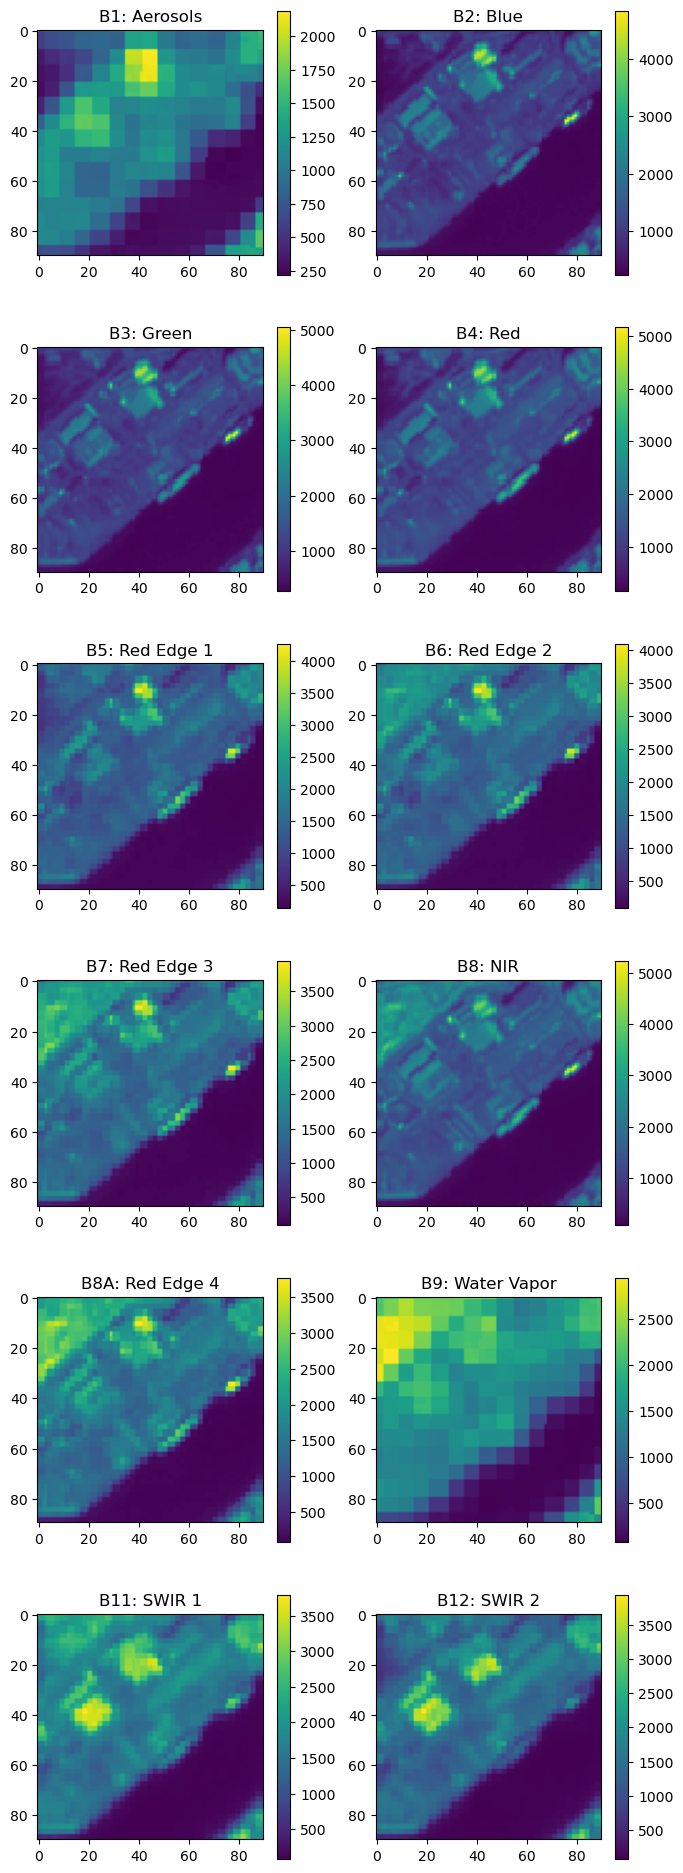

In [10]:
du.plotArray(ds_osaka[0][0])

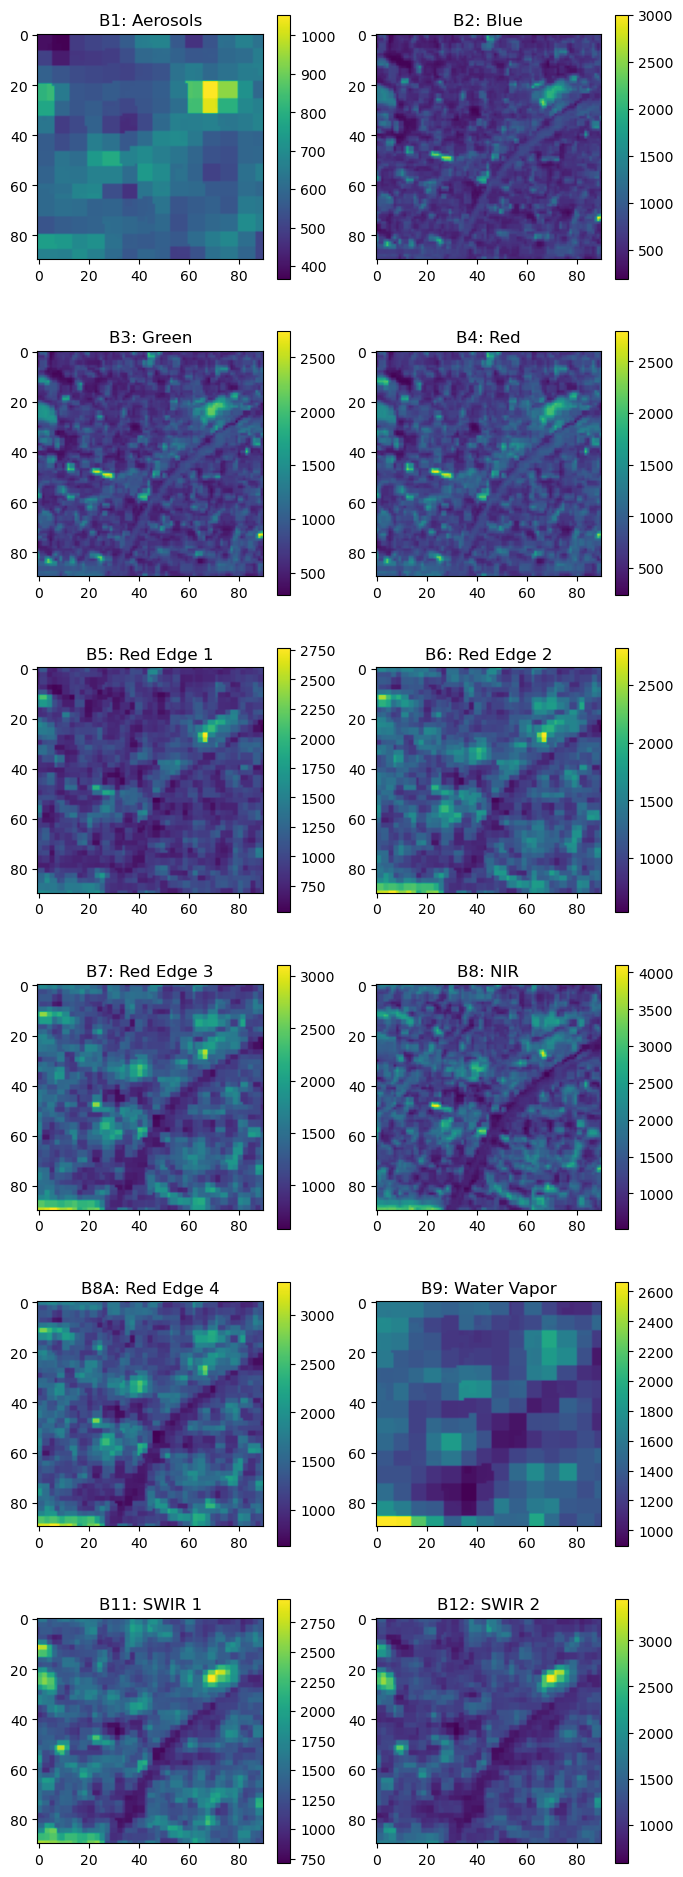

In [11]:
du.plotArray(ds_tokyo[0][0])

### Check dataset

In [80]:
len(ds_osaka), len(ds_tokyo)

(1145, 3286)

In [81]:
# Check for shape discrepancies
for i in range(len(ds_osaka)):
    ds_osaka[i]

In [82]:
# Check for shape discrepancies
for i in range(len(ds_tokyo)):
    ds_tokyo[i]

In [87]:
ds_tokyo.channel_max

[5232.0,
 12216.0,
 14792.0,
 16032.0,
 15665.0,
 15742.0,
 15663.0,
 15607.0,
 15569.0,
 7385.0,
 14959.0,
 15063.0]

### Create FastAI dataloaders

In [26]:
dl = DataLoaders().from_dsets(ds_tokyo, ds_osaka, bs= 8, device=torch.device('cuda'))

#### Validate the shape and len

In [24]:
# Check that dimensions are right
test_batch = dl.one_batch()

In [26]:
# Validate shape
test_batch[0].shape, test_batch[1].shape

(torch.Size([8, 12, 90, 90]), torch.Size([8, 10]))

In [27]:
# Validate len
len(dl.train_ds), len(dl.valid_ds)

(3286, 1145)

## Training the Model

### Extract the max for normalisation

In [27]:
dl.train_ds.channel_max

[5232.0,
 12216.0,
 14792.0,
 16032.0,
 15665.0,
 15742.0,
 15663.0,
 15607.0,
 15569.0,
 7385.0,
 14959.0,
 15063.0]

In [28]:
dl.train_ds.UMP_max

[179.837,
 69.9,
 19.801067,
 0.01881086,
 1.0278143,
 262.0,
 217.22,
 0.4841617,
 34.540844,
 45.97128]

### Model using custom weights (12 channels)
- Using weights from previous model
- Expand model to accept 12 channels instead of just 3

In [12]:
# Load weights from IM2ELEVATION and delete unnecessary layers
checkpoint = torch.load(CHECKPT_PATH)

to_delete = []
for layer in checkpoint["state_dict"].keys():
    if any([word in layer.upper() for word in ["HARM", "R.CONV4", "R.BN4"]]):
    # if any([word in layer.upper() for word in ["HARM", "R.CONV3", "R.BN3", "R.CONV4", "R.BN4"]]):
        to_delete.append(layer)
print(to_delete)

for i in to_delete:
    checkpoint["state_dict"].pop(i)

# Load Weights
ssl._create_default_https_context = ssl._create_unverified_context

original_model = senet.senet154()

Encoder = modules.E_senet(original_model, dl.train_ds.channel_max)
model = net.model(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])

# Load trimmed im2elevation weights
model.load_state_dict(checkpoint["state_dict"], strict=False)

# Clear memory
del checkpoint
gc.collect()
torch.cuda.empty_cache()

['E.Harm.dct', 'E.Harm.weight', 'E.Harm.bias', 'R.conv4.weight', 'R.conv4.bias']


#### Merging the channels

To merge the channels, the inputs are put to run in parallel until around the mid-way point of the senet backbone, before merging them...?

In [13]:
model = net.model_n12(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])
# merged_model = convert_network(model, torch.float16)

### Check Model Sanity

In [29]:
test_batch = dl.one_batch()[0]
test_batch.dtype

torch.float32

In [30]:
model.eval()
model.cuda()
model(test_batch).shape

torch.Size([8, 10])

### Loss and Metrics

In [31]:
# Loss Function

def mse_weighted(pred, actual, UMP_max= dl.train_ds.UMP_max):
    """
    Weighted loss function that normalises the predictions based on the parameters used to normalise the actual during training
    """
    loss = tensor(0).float()
    loss.requires_grad_(True)
    for ump in range(pred.shape[1]):
        # loss = torch.add(loss, F.mse_loss(pred[:, ump], actual[:, ump]))
        loss = torch.add(loss, torch.div(F.mse_loss(pred[:, ump], actual[:, ump]), UMP_max[ump]**2))
    if loss.isnan().sum() > 1:
        raise ValueError([pred, actual])
    return loss.float()


In [32]:
# List of metrics
"""
"AverageHeightArea", 
"AverageHeightBuilding", 
"AverageHeightTotalArea", 
"Displacement", 
"FrontalAreaIndex",
"MaximumHeight",
"PercentileHeight",
"PlanarAreaIndex",
"RoughnessLength",
"StandardDeviation"
"""
def AverageHeightArea_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 0], actual[:, 0]))

def AverageHeightBuilding_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 1], actual[:, 1]))

def AverageHeightTotalArea_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 2], actual[:, 2]))

def Displacement_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 3], actual[:, 3]))

def FrontalAreaIndex_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 4], actual[:, 4]))

def MaximumHeight_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 5], actual[:, 5]))

def PercentileHeight_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 6], actual[:, 6]))

def PlanarAreaIndex_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 7], actual[:, 7]))

def RoughnessLength_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 8], actual[:, 8]))

def StandardDeviation_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 9], actual[:, 9]))

metrics = [
    AverageHeightArea_RMSE, 
    AverageHeightBuilding_RMSE,
    AverageHeightTotalArea_RMSE,
    Displacement_RMSE,
    FrontalAreaIndex_RMSE,
    MaximumHeight_RMSE,
    PercentileHeight_RMSE,
    PlanarAreaIndex_RMSE,
    RoughnessLength_RMSE,
    StandardDeviation_RMSE
]

### Train Model

In [33]:
# Need better loss due to scale difference
model.train()
learn = Learner(dl, model, loss_func= mse_weighted, metrics= metrics, cbs=[MixedPrecision, FP16TestCallback])

SuggestedLRs(valley=0.00010964782268274575)

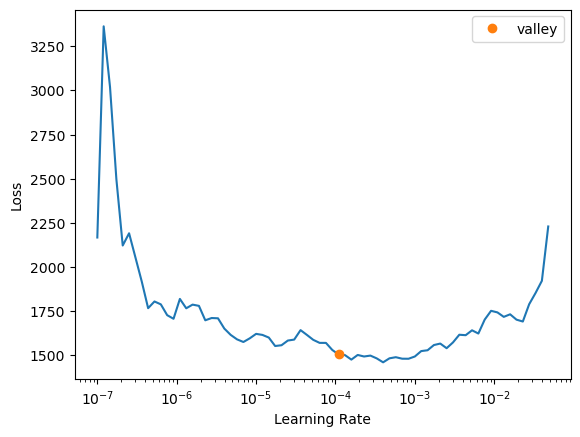

In [34]:
learn.lr_find()

epoch,train_loss,valid_loss,AverageHeightArea_RMSE,AverageHeightBuilding_RMSE,AverageHeightTotalArea_RMSE,Displacement_RMSE,FrontalAreaIndex_RMSE,MaximumHeight_RMSE,PercentileHeight_RMSE,PlanarAreaIndex_RMSE,RoughnessLength_RMSE,StandardDeviation_RMSE,time
0,1430.931030,15940.688477,19.808176,14.176114,29.858525,1.960693,12.711718,81.386688,27.819466,7.960174,8.154973,10.505549,04:04
1,1130.949341,2309.678711,15.637377,10.026519,6.995236,0.759594,1.514620,82.876887,31.002883,0.795998,4.812376,9.536967,04:05
2,804.028564,3599.217529,17.765478,11.489279,6.844729,0.837535,0.751917,86.147928,33.226150,0.979520,4.869010,10.436254,04:06


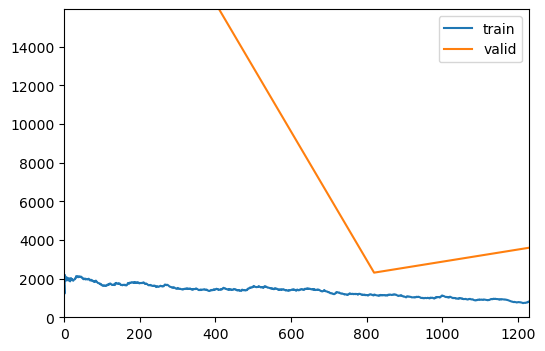

epoch,train_loss,valid_loss,AverageHeightArea_RMSE,AverageHeightBuilding_RMSE,AverageHeightTotalArea_RMSE,Displacement_RMSE,FrontalAreaIndex_RMSE,MaximumHeight_RMSE,PercentileHeight_RMSE,PlanarAreaIndex_RMSE,RoughnessLength_RMSE,StandardDeviation_RMSE,time
0,735.109680,607.301819,16.905221,10.413530,5.618686,0.366327,0.710875,82.959006,32.445058,0.700930,5.026128,10.486146,04:02
1,658.297485,14162.537109,18.971162,11.179592,26.815465,1.866244,6.742545,91.743604,32.885676,4.466805,9.006771,13.448772,04:06
2,588.916016,10216.376953,17.173113,11.165095,9.692880,1.421828,1.673596,84.977745,31.004713,1.228083,5.277883,9.871970,04:08
3,509.401672,22935.015625,18.061196,8.846878,18.766705,2.064103,3.046135,88.795649,32.661039,1.991948,5.695545,11.328073,04:07
4,378.913208,963.200134,15.777287,11.512472,7.304645,0.291436,0.785886,84.288470,29.375060,1.386216,5.774652,9.145495,04:08
5,298.869202,145.539230,18.112670,10.836199,5.419373,0.161657,0.239250,83.083570,32.618864,0.369606,4.961433,10.669211,04:07
6,239.210098,72.000252,16.256728,10.037008,5.834979,0.128496,0.399973,82.934917,31.450737,0.401803,4.865824,10.264699,04:07
7,161.434631,137.580948,15.006096,8.863495,7.252992,0.165730,0.436478,83.370796,30.154497,0.366376,5.032257,10.036183,04:08
8,142.991669,114.541687,15.200188,9.136881,6.630512,0.137206,0.731013,83.267590,30.054214,0.468494,4.816124,9.987535,04:08
9,121.796082,173.802872,15.687432,9.628215,5.917451,0.150644,0.452834,82.744297,30.379223,0.642139,4.340145,9.679178,04:07


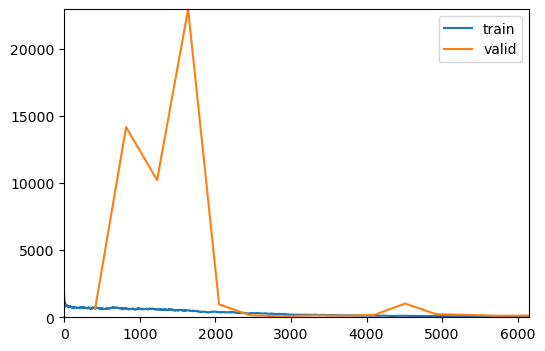

In [36]:
learn.fine_tune(15, 0.0001, freeze_epochs= 3, cbs= [ShowGraphCallback()])

In [37]:
# Plateaus around 30
name = "new_12ch_8_15" # <description>_<batch_size>_<epochs>
torch.save(model.state_dict(), f"trained_models/model_weight_{name}.pth")
torch.save(model, f"trained_models/model_{name}.pth")

with open(f"trained_models/model_records_{name}.pkl", "wb") as f:
    pickle.dump(learn.recorder.values, f)